In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import necessary libraries
import os
import sys
from pathlib import Path
# Ensure the src directory is accessible
sys.path.append('./src')

# Get data

In [2]:
from tdc.single_pred import Tox
karim_data = Tox(name='hERG_Karim')
data_split = karim_data.get_split(method='scaffold', seed=42)
print(f"There are {data_split['train']} training samples, {data_split['valid']} validation samples, and {data_split['test']} test samples.")

Found local copy...
Loading...
Done!
100%|██████████| 13445/13445 [00:05<00:00, 2307.31it/s]

There are       Drug_ID                                               Drug  Y
0        8640  O=C1NCCN1CC[N+]1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc2...  0
1       11377  O=C(Cc1ccc(-n2cnnn2)cc1)N1CCN(CCc2ccc3nonc3c2)CC1  1
2        1461  NC(=O)c1ncc(N[C@@H]2CCCC[C@@H]2N)cc1Nc1cccc(C(...  1
3        6646  Cc1cc(C)nc(Nc2cc(N[C@@H]3CCCC[C@@H]3N)cnc2C(N)...  1
4         379  COc1cc(C)nc(Nc2cc(N[C@@H]3CCCC[C@@H]3N)cnc2C(N...  1
...       ...                                                ... ..
9406     5238  CC(C)(C)c1cc(NC(=O)n2ccc3cc(Oc4ncnc5c4CCNC5)cc...  1
9407     6201  Cc1ccc2c(C3CCN(CCc4c(C)ccc5c4ccc(=O)n5C)CC3)cc...  1
9408    11725  CCOC(=O)C1=C(CN2CCOCC2)NC(c2nccs2)=NC1c1ccc(F)...  1
9409    12714  CCCCCCOC(=O)NC(=N)c1ccc(NCc2nc3cc(C(=O)N(CCC(=...  1
9410    13134  Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)...  0

[9411 rows x 3 columns] training samples,       Drug_ID                                               Drug  Y
0         536        O=C(c1ccccc1C(F)(F)F)N(CC1CCCC1)[C@H]1CCNC

# LLM based model

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, RobertaConfig, RobertaForSequenceClassification


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Define a custom dataset class
class SMILESDataset(Dataset):
    def __init__(self, smiles, labels, tokenizer, max_length=128):
        self.smiles = smiles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        label = self.labels[idx]
        encoded = self.tokenizer(smile, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        encoded_input = {key: val.squeeze(0) for key, val in encoded.items()}
        return encoded_input, torch.tensor(label, dtype=torch.float)

    
# get pretrained tokenizer
local_tokenizer_path = './huggingface/PubChem10M_SMILES_BPE_450k'  # Path where tokenizer files are stored
tokenizer = AutoTokenizer.from_pretrained(local_tokenizer_path) 
# if online: tokenizer = AutoTokenizer.from_pretrained(seyonec/PubChem10M_SMILES_BPE_450k) 


# Load existing configuration and modify it
config_path = './huggingface/ChemBERTa-zinc-base-v1/config.json'
model_config = RobertaConfig.from_pretrained(config_path)
model_config.vocab_size = 7924  # Updating the vocab size
model_config.num_labels = 1  # Ensure this is set for binary classification


# Reinitialize the model with updated configuration
model = RobertaForSequenceClassification(config=model_config)


# Prepare data
train_smiles = data_split['train']['Drug'].tolist()
train_labels = data_split['train']['Y'].tolist()
valid_smiles = data_split['valid']['Drug'].tolist()
valid_labels = data_split['valid']['Y'].tolist()

train_dataset = SMILESDataset(train_smiles, train_labels, tokenizer)
valid_dataset = SMILESDataset(valid_smiles, valid_labels, tokenizer)


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()


def train_epoch(model, data_loader, optimizer, device, criterion):
    model.train()
    total_loss = 0
    for inputs, labels in data_loader:
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device).unsqueeze(1)
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)



In [7]:
from evaluate import eval

def eval_model(model, data_loader, device, criterion, verbose=False):
    model.eval()
    predictions = []
    real_values = []
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels.to(device).unsqueeze(1))
            total_loss += loss.item()
            preds = torch.sigmoid(outputs.logits)
            predictions.extend(preds.flatten().tolist())
            real_values.extend(labels.tolist())
    
    return {
        'loss': total_loss,
        'metrics': eval(real_values, predictions, verbose=verbose),
    }
    


In [8]:
# Train the model
checkpoint_dir = './src/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
num_epochs = 100
total_train_losses = []
total_valid_losses = []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device, criterion)
    valid_result = eval_model(model, valid_loader, device, criterion)
    total_train_losses.append(train_loss)
    total_valid_losses.append(valid_result['loss'])
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_result['loss']:.4f}")

    # Save the checkpoint every two epochs
    if epoch % 2 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, checkpoint_path)

Epoch 0, Train Loss: 0.6769, Validation Loss: 55.2452
Epoch 1, Train Loss: 0.6444, Validation Loss: 54.9094
Epoch 2, Train Loss: 0.6150, Validation Loss: 53.6050
Epoch 3, Train Loss: 0.5939, Validation Loss: 61.0028
Epoch 4, Train Loss: 0.5675, Validation Loss: 55.9971
Epoch 5, Train Loss: 0.5487, Validation Loss: 53.7522
Epoch 6, Train Loss: 0.5470, Validation Loss: 52.8785
Epoch 7, Train Loss: 0.5469, Validation Loss: 51.1362
Epoch 8, Train Loss: 0.5355, Validation Loss: 54.6660
Epoch 9, Train Loss: 0.5111, Validation Loss: 57.4103
Epoch 10, Train Loss: 0.5364, Validation Loss: 62.2459
Epoch 11, Train Loss: 0.5082, Validation Loss: 55.8135
Epoch 12, Train Loss: 0.4747, Validation Loss: 59.5490
Epoch 13, Train Loss: 0.5094, Validation Loss: 59.9614
Epoch 14, Train Loss: 0.6262, Validation Loss: 54.9900
Epoch 15, Train Loss: 0.5655, Validation Loss: 55.0103
Epoch 16, Train Loss: 0.5271, Validation Loss: 58.8801
Epoch 17, Train Loss: 0.4968, Validation Loss: 54.9245
Epoch 18, Train Loss

KeyboardInterrupt: 

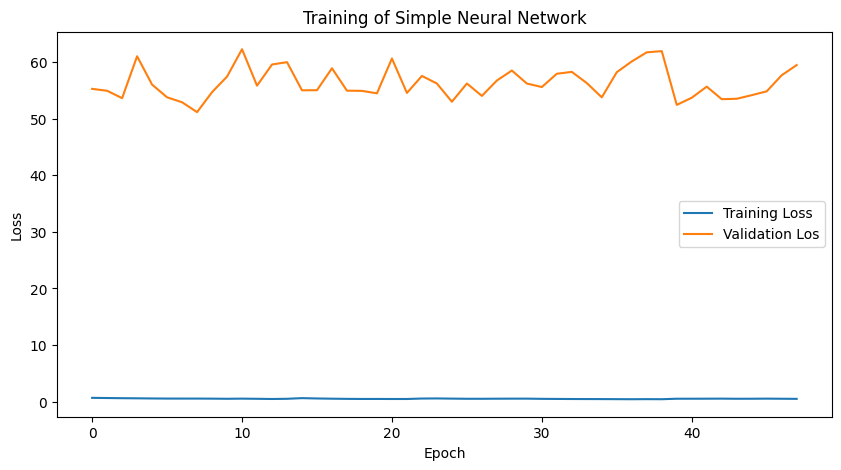

In [10]:
import matplotlib.pyplot as plt

# Converting tensors to lists of scalars
visual_train_losses = [x for x in total_train_losses]
visual_valid_losses = [x for x in total_valid_losses]

# Plotting the values
plt.figure(figsize=(10, 5))
plt.plot(visual_train_losses, label='Training Loss')
plt.plot(visual_valid_losses, label='Validation Los')
plt.title('Training of Simple Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation on Test Data

In [43]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f'Loaded checkpoint from epoch {epoch} with loss {loss:.4f}')
    return model, optimizer, epoch, loss


# select the best model:
epoch_n = 34
checkpoint_path = f'./src/checkpoints/checkpoint_epoch_{epoch_n}.pt'

model, optimizer, start_epoch, train_loss = load_checkpoint(model, optimizer, checkpoint_path)

test_smiles = data_split['test']['Drug'].tolist()
test_labels = data_split['test']['Y'].tolist()
test_dataset = SMILESDataset(test_smiles, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
test_performance = eval_model(model, test_loader, device, criterion, verbose=True)


Loaded checkpoint from epoch 34 with loss 0.4563
Accuracy: 0.7159851301115242
ROC AUC Score: 0.7914378882966284
Precision: 0.6969909027291813
Recall: 0.7505651846269782
F1 Score: 0.7227866473149492
Matthews Correlation Coefficient: 0.4336914538773981
Specificity (Negative Prediction Accuracy): 0.6823184152604549
